https://medium.com/@Rehan_Sayyad/how-to-use-convolutional-neural-networks-for-time-series-classification-80575131a474

https://machinelearningmastery.com/cnn-models-for-human-activity-recognition-time-series-classification/

In [1]:
import sys
import os
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
module_path = os.path.abspath(os.path.join('../..'))

sys.path.insert(1, module_path + '/src')
import audio_time_series_classification as preproject
import utility

sys.path.insert(1, module_path + '/src/models/')
import helper

from sktime.utils.data_io import load_from_tsfile_to_dataframe
from sktime.utils.data_processing import from_nested_to_2d_array
import matplotlib.pyplot as plt
from sklearn import preprocessing

from keras.utils import np_utils
import keras
from keras.models import Model
from keras.models import Sequential
from keras.layers import Conv1D, ZeroPadding1D, MaxPooling1D, BatchNormalization, Activation, Dropout, Flatten, Dense


figure_path = module_path + '/figures/'

In [2]:
X_train, y_train_ = load_from_tsfile_to_dataframe(module_path + f'/data/ts_files/UiT_5s_noOverlap_TRAIN.ts')
X_test, y_test_ = load_from_tsfile_to_dataframe(module_path + f'/data/ts_files/UiT_5s_noOverlap_TEST.ts')
X_val, y_val_ = load_from_tsfile_to_dataframe(module_path + f'/data/ts_files/UiT_5s_noOverlap_VAL.ts')

X_train, y_train_= shuffle(X_train, y_train_, random_state = 42)

X_train, X_test, X_val = from_nested_to_2d_array(X_train), from_nested_to_2d_array(X_test), from_nested_to_2d_array(X_val)

cols = np.arange(len(X_test.columns))
X_train.columns, X_test.columns, X_val.columns = cols, cols, cols

y_train_, y_test_, y_val_ = pd.Series(y_train_), pd.Series(y_test_), pd.Series(y_val_)
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
X_val = X_val.to_numpy()

X_train, y_train_= shuffle(X_train, y_train_, random_state = 42)
X_val, y_val_= shuffle(X_val, y_val_, random_state = 42)

X_train = X_train.reshape(X_train.shape[0],X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1], 1)

## Keeping the original classes

In [ ]:
indices_1 = np.where(y_train_ == 'normal')[0]
indices_2 = np.where(y_train_ == 'exp_wheeze')[0]
indices_3 = np.where(y_train_ == 'insp_crackle')[0]
indices_4 = np.where(y_train_ == 'insp_wheeze')[0]
indices_5 = np.where(y_train_ == 'exp_crackle')[0]
#indices_train = np.concatenate((indices_1[0:25], indices_2[:25], indices_3[:25], indices_4, indices_5))
indices_train = np.concatenate((indices_2[:25], indices_3[:25], indices_4, indices_5))

indices_1 = np.where(y_test_ == 'normal')[0]
indices_2 = np.where(y_test_ == 'exp_wheeze')[0]
indices_3 = np.where(y_test_ == 'insp_crackle')[0]
indices_4 = np.where(y_test_ == 'insp_wheeze')[0]
indices_5 = np.where(y_test_ == 'exp_crackle')[0]
#indices_test = np.concatenate((indices_1, indices_2, indices_3, indices_4, indices_5))
indices_test = np.concatenate((indices_2, indices_3, indices_4, indices_5))

indices_1 = np.where(y_val_ == 'normal')[0]
indices_2 = np.where(y_val_ == 'exp_wheeze')[0]
indices_3 = np.where(y_val_ == 'insp_crackle')[0]
indices_4 = np.where(y_val_ == 'insp_wheeze')[0]
indices_5 = np.where(y_val_ == 'exp_crackle')[0]
#indices_val = np.concatenate((indices_1, indices_2, indices_3, indices_4, indices_5))
indices_val = np.concatenate((indices_2, indices_3, indices_4, indices_5))

In [ ]:
le = preprocessing.LabelEncoder()

le.fit(y_train_[indices_train])
num_classes = len(le.classes_)
y_train = le.transform(y_train_[indices_train])
y_test = le.transform(y_test_[indices_test])
y_val = le.transform(y_val_[indices_test])

y_train = np_utils.to_categorical(y_train, num_classes = num_classes)
y_test = np_utils.to_categorical(y_test, num_classes = num_classes)
y_val = np_utils.to_categorical(y_val, num_classes = num_classes)

## Creating subclasses 

In [3]:
y_train_new = y_train_.copy(deep = True)

y_train_new[y_train_new == 'exp_wheeze'] = 'wheeze'
y_train_new[y_train_new == 'insp_wheeze'] = 'wheeze'
y_train_new[y_train_new == 'exp_crackle'] = 'crackle'
y_train_new[y_train_new == 'insp_crackle'] = 'crackle'

y_test_new = y_test_.copy(deep = True)

y_test_new[y_test_new == 'exp_wheeze'] = 'wheeze'
y_test_new[y_test_new == 'insp_wheeze'] = 'wheeze'
y_test_new[y_test_new == 'exp_crackle'] = 'crackle'
y_test_new[y_test_new == 'insp_crackle'] = 'crackle'

y_val_new = y_val_.copy(deep = True)

y_val_new[y_val_new == 'exp_wheeze'] = 'wheeze'
y_val_new[y_val_new == 'insp_wheeze'] = 'wheeze'
y_val_new[y_val_new == 'exp_crackle'] = 'crackle'
y_val_new[y_val_new == 'insp_crackle'] = 'crackle'

In [4]:
y_train_new.value_counts()

normal     927
crackle    711
wheeze     684
dtype: int64

In [4]:
indices_1 = np.where(y_train_new == 'normal')[0]
indices_2 = np.where(y_train_new == 'wheeze')[0]
indices_3 = np.where(y_train_new == 'crackle')[0]
#indices_train = np.concatenate((indices_2, indices_3))
indices_train = np.concatenate((indices_1[:711], indices_2, indices_3))


indices_1 = np.where(y_test_new == 'normal')[0]
indices_2 = np.where(y_test_new == 'wheeze')[0]
indices_3 = np.where(y_test_new == 'crackle')[0]
#indices_test = np.concatenate((indices_2, indices_3))
indices_test = np.concatenate((indices_1, indices_2, indices_3))

indices_1 = np.where(y_val_new == 'normal')[0]
indices_2 = np.where(y_val_new == 'wheeze')[0]
indices_3 = np.where(y_val_new == 'crackle')[0]
#indices_test = np.concatenate((indices_2, indices_3))
indices_val = np.concatenate((indices_1, indices_2, indices_3))

In [5]:
le = preprocessing.LabelEncoder()

le.fit(y_train_new[indices_train])
num_classes = len(le.classes_)
y_train = le.transform(y_train_new[indices_train])
y_test = le.transform(y_test_new[indices_test])
y_val = le.transform(y_val_new[indices_val])

y_train = np_utils.to_categorical(y_train, num_classes = num_classes)
y_test = np_utils.to_categorical(y_test, num_classes = num_classes)
y_val = np_utils.to_categorical(y_val, num_classes = num_classes)

# Models

In [9]:
model = Sequential()
batch_size = 100
epochs = 50
input_shape=(X_train.shape[1], 1)
model.add(Conv1D(128, kernel_size=3,padding = 'same',activation= 'relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=(2)))
model.add(Conv1D(128,kernel_size=3,padding = 'same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=(2)))
model.add(Flatten())
model.add(Dense(64, activation= 'tanh'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 25000, 128)        512       
_________________________________________________________________
batch_normalization (BatchNo (None, 25000, 128)        512       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 12500, 128)        0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 12500, 128)        49280     
_________________________________________________________________
batch_normalization_1 (Batch (None, 12500, 128)        512       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 6250, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 800000)           

In [ ]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=20, activation='relu', input_shape=(n_timesteps,1)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Comments

* Adding batch normalization makes so that only one class is guessed always

In [6]:
batch_size = 100
epochs = 50
input_shape=(X_train.shape[1], 1)

In [7]:
model = Sequential()

model.add(Conv1D(filters=50, kernel_size=10, activation='relu', input_shape=input_shape))
#model.add(BatchNormalization()) 
model.add(MaxPooling1D(pool_size=50))
model.add(Flatten())
model.add(Dense(1500, activation='relu'))
#model.add(Dropout(0.2))
#model.add(Dense(500, activation='relu'))
#model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))
model.compile(optimizer='adam', loss='mse')

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 24991, 50)         550       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 499, 50)           0         
_________________________________________________________________
flatten (Flatten)            (None, 24950)             0         
_________________________________________________________________
dense (Dense)                (None, 1500)              37426500  
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 4503      
Total params: 37,431,553
Trainable params: 37,431,553
Non-trainable params: 0
_________________________________________________________________


In [27]:
X_train[indices_train].shape

(4012, 20000, 1)

In [11]:
model.compile(optimizer='adam', loss='mse')
model.fit(X_train[indices_train], y_train, epochs = epochs,
          batch_size = batch_size,
          verbose = 1,
         validation_data = (X_val[indices_val], y_val))

Epoch 1/50
22/22 [==============================] - 173s 8s/step - loss: 0.2598 - val_loss: 0.3742
Epoch 2/50
22/22 [==============================] - 169s 8s/step - loss: 0.2373 - val_loss: 0.4212
Epoch 3/50
22/22 [==============================] - 171s 8s/step - loss: 0.2304 - val_loss: 0.4388
Epoch 4/50
22/22 [==============================] - 171s 8s/step - loss: 0.2261 - val_loss: 0.4233
Epoch 5/50
22/22 [==============================] - 170s 8s/step - loss: 0.2234 - val_loss: 0.4297
Epoch 6/50
22/22 [==============================] - 168s 8s/step - loss: 0.2277 - val_loss: 0.4326
Epoch 7/50
22/22 [==============================] - 169s 8s/step - loss: 0.2236 - val_loss: 0.4239
Epoch 8/50
22/22 [==============================] - 174s 8s/step - loss: 0.2234 - val_loss: 0.3975
Epoch 9/50
22/22 [==============================] - 174s 8s/step - loss: 0.2246 - val_loss: 0.3747
Epoch 10/50
22/22 [==============================] - 176s 8s/step - loss: 0.2224 - val_loss: 0.3828
Epoch 11/

'f.set_size_inches(10, 10)\n\nfor item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +\n             ax.get_xticklabels() + ax.get_yticklabels()):\n    item.set_fontsize(15)'

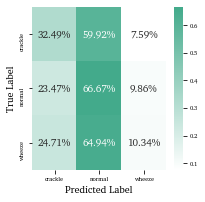

In [12]:
classes = le.classes_

result = model.predict(X_test[indices_test])
y_pred = np.argmax(result, axis = 1)
y_true = np.argmax(y_test, axis = 1)

f, ax = utility.plot_cm(y_true, y_pred, module_path = module_path, class_names = classes, color_index = 6)

#f.savefig(figure_path + f'TSC/cm_uit_CNN_5s.pdf', bbox_inches='tight')


'''f.set_size_inches(10, 10)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)'''

'f.set_size_inches(10, 10)\n\nfor item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +\n             ax.get_xticklabels() + ax.get_yticklabels()):\n    item.set_fontsize(15)'

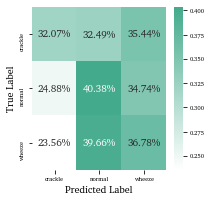

In [33]:
classes = le.classes_

result = model.predict(X_test[indices_test])
y_pred = np.argmax(result, axis = 1)
y_true = np.argmax(y_test, axis = 1)

f, ax = utility.plot_cm(y_true, y_pred, module_path = module_path, class_names = classes, color_index = 6)

f.savefig(figure_path + f'TSC/cm_uit_CNN_5s.pdf', bbox_inches='tight')


'''f.set_size_inches(10, 10)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)'''

In [141]:
#Iterate thru all the layers of the model
for layer in model.layers:
    if 'conv' in layer.name:
        weights, bias= layer.get_weights()
        print(layer.name, filters.shape)
        
        #normalize filter values between  0 and 1 for visualization
        f_min, f_max = weights.min(), weights.max()
        filters = (weights - f_min) / (f_max - f_min)  
        print(filters.shape[3])
        filter_cnt=1
        
        #plotting all the filters
        for i in range(filters.shape[3]):
            #get the filters
            filt=filters[:,:,:, i]
            #plotting each of the channel, color image RGB channels
            for j in range(filters.shape[0]):
                ax= plt.subplot(filters.shape[3], filters.shape[0], filter_cnt  )
                ax.set_xticks([])
                ax.set_yticks([])
                plt.imshow(filt[:,:, j])
                filter_cnt+=1
        plt.show()

NameError: name 'filters' is not defined

In [24]:
model.layers

In [23]:
from vis.visualization import visualize_saliency
from vis.utils import utils
import matplotlib.pyplot as plt
import numpy as np

ImportError: cannot import name 'imresize' from 'scipy.misc' (/home/andrine/anaconda3/lib/python3.7/site-packages/scipy/misc/__init__.py)